In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from scipy.linalg import orth
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.decomposition import PCA
from terminaltables import AsciiTable as Table
from tqdm.notebook import tqdm

In [5]:
def estimate_optimal_ncomponents(mat):
    pca = PCA()
    pca.fit(mat)
    opt = []
    total_var = 0
    nc = 0
    for var in pca.explained_variance_ratio_:
        total_var += var
        nc += 1
        if total_var >= 0.99:
            opt.append(nc)
            break
        elif total_var >= 0.95:
            opt.append(nc)
    return opt[0], opt[-1], len(pca.explained_variance_ratio_)

def pca_transform(mat):
    _, n, _ = estimate_optimal_ncomponents(mat)
    pca = PCA(n_components=n)
    return pca.fit_transform(mat)

def cosine_sim(u, v):
    return 1-cosine(u, v)

In [11]:
data = ['mnist', 'fmnist', 'cifar']
lrs = [1e-1, 1e-2, 1e-3]
clfs = {
#     'resnet18': [4096, 60000],
    'resnet18': 60000,
#     'fcn': [16, 64, 256, 1024, 4096, 16384, 60000],
    'fcn': 60000,
#     'svm': [4096],
}

files = {}
for d in data:
    for lr in lrs:
        for clf, batches in clfs.items():
            if clf == 'svm' and d=='cifar':
                lr *= 1e-3
            elif clf == 'svm':
                    lr *= 1e-2
            files[
                '../ckpts/{}_centralized/history/'
                'clf_{}_paradigm_sgd_lr_{}_decay_'
                '1e-05_batch_{}.pkl'.format(d, clf, lr, 4096)] = '{}/{}/{}'.format(d,clf,lr)

# Same Dataset Different Models

[0:21]


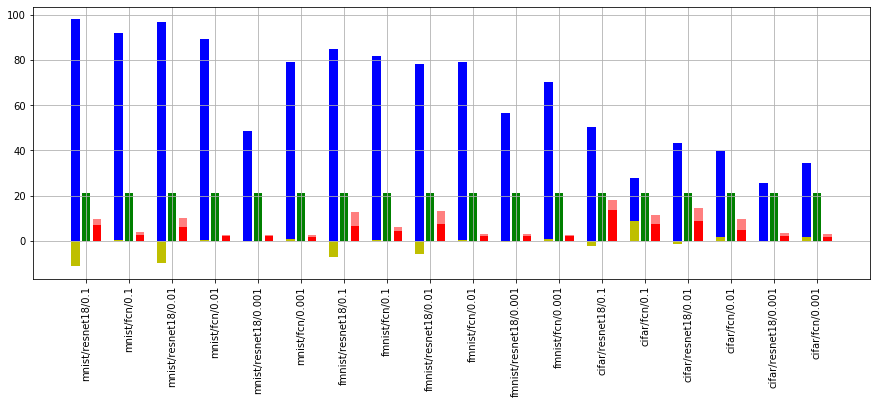

[20:41]


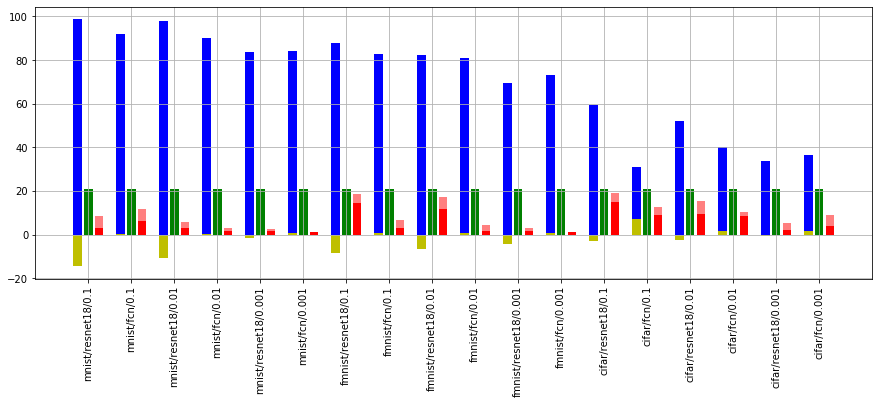

[40:61]


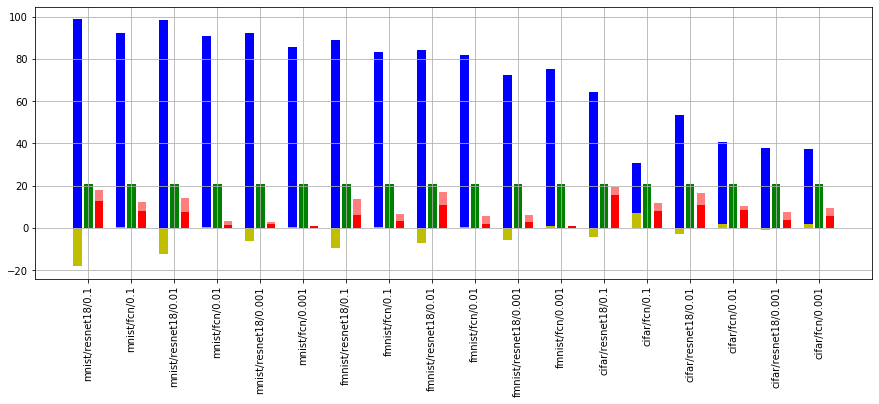

[60:81]


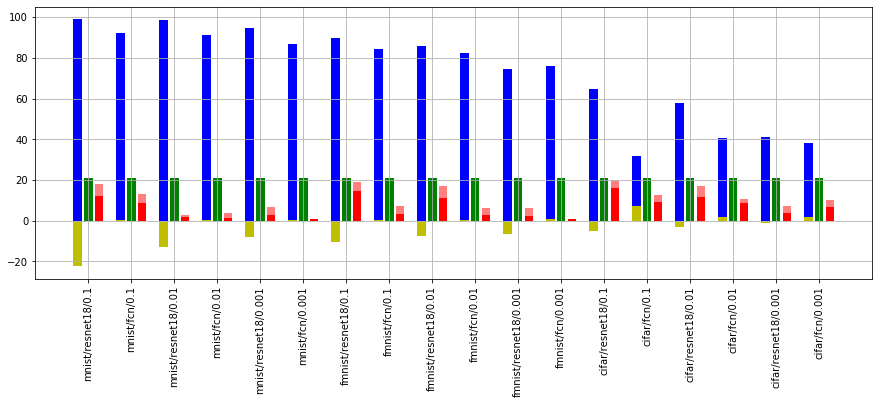

[80:101]


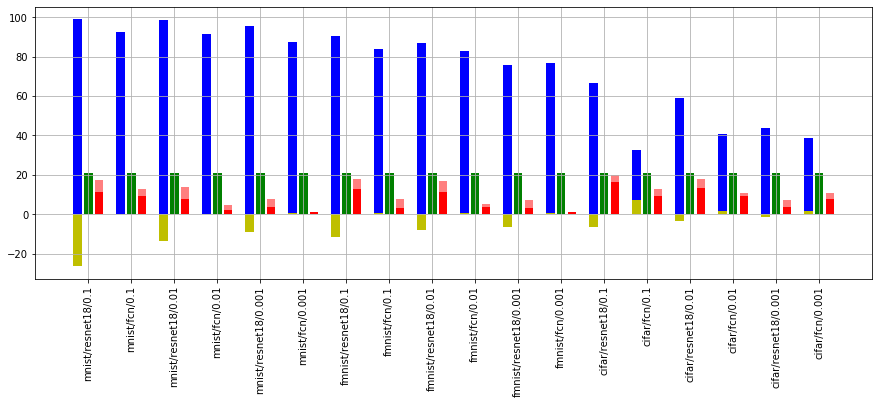

In [12]:
epochs = 101
len_split = 20

nc_95 = defaultdict(list)
nc_90 = defaultdict(list)
for ep in tqdm(range(len_split, epochs, len_split), leave=False):
    idx = 1
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(111)
    tick_names = []
    ticks = []
    start_ep = ep-len_split
    end_ep = ep + 1
    print('[{}:{}]'.format(start_ep, end_ep))
    table = [['expt', 'max(acc)', 'min(loss)', 'opt(0.95)', 'opt(0.99)']]
    for file, tick_name in tqdm(files.items(), leave=False):
        if not ('' in tick_name):
            continue
        ticks.append(idx)
        tick_names.append(tick_name)
        _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
        acc_test = acc_test[start_ep:end_ep]
        loss_test = loss_test[start_ep:end_ep]
        best_acc = np.max(acc_test)
        best_loss = np.min(loss_test)
        grads = grads[start_ep:end_ep]
        tot_opt_95 = 0
        tot_opt_99 = 0
        tot_epochs = 0
        for layer_num in range(len(grads[0])):
            accum = []
            for epoch_num in range(len(grads)):
                g = grads[epoch_num][layer_num]
                shape = g.shape
                accum.append(g.reshape(1, -1).cpu().numpy())
            stack_g = np.vstack(accum)
            o_95, o_99, o_epochs = estimate_optimal_ncomponents(stack_g.T)
            tot_opt_95 += o_95
            tot_opt_99 += o_99
            tot_epochs += 1
        table.append([tick_name, 
                      '{:.4f}'.format(best_acc), 
                      '{:.4f}'.format(best_loss),
                      '{:.4f}'.format(tot_opt_95/tot_epochs), 
                      '{:.4f}'.format(tot_opt_99/tot_epochs)])
        nc_95[tick_name].append(tot_opt_99/tot_epochs)
        nc_90[tick_name].append(tot_opt_95/tot_epochs)
        plt.bar(idx-0.25, best_acc*100, width = 0.2, color='b')
        plt.bar(idx-0.25, best_loss, width=0.2, color='y')
        plt.bar(idx, len(grads), width=0.2, color='g')
        plt.bar(idx+0.25, tot_opt_95/tot_epochs, width=0.2, color='r')
        plt.bar(idx+0.25, tot_opt_99/tot_epochs, width=0.2, color='r', alpha=0.5)
        idx += 1
#     table = Table(table)
#     print(table.table)
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(tick_names, rotation='vertical')
    ax1.grid()
    plt.show()
    

In [ ]:
epochs = 101
len_split = 20

nc_95 = defaultdict(list)
nc_90 = defaultdict(list)
for ep in tqdm(range(len_split, epochs, len_split), leave=False):
    idx = 1
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(111)
    tick_names = []
    ticks = []
    start_ep = ep-len_split
    end_ep = ep + 1
    print('[{}:{}]'.format(start_ep, end_ep))
    for file, tick_name in tqdm(files.items(), leave=False):
        if 'resnet' not in tick_name:
            continue
        print(tick_name)
        ticks.append(idx)
        tick_names.append(tick_name)
        _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
        acc_test = acc_test[start_ep:end_ep]
        loss_test = loss_test[start_ep:end_ep]
        best_acc = np.max(acc_test)
        best_loss = np.min(loss_test)
        grads = grads[start_ep:end_ep]
        tot_opt_95 = 0
        tot_opt_99 = 0
        tot_epochs = 0
        table = [['shape', 'stack', 'opt(0.90)', 'opt(0.95)']]
        for layer_num in range(len(grads[0])):
            accum = []
            for epoch_num in range(len(grads)):
                g = grads[epoch_num][layer_num]
                shape = g.shape
                accum.append(g.reshape(1, -1).cpu().numpy())
            stack_g = np.vstack(accum)
            o_95, o_99, o_epochs = estimate_optimal_ncomponents(stack_g.T)
            tot_opt_95 += o_95
            tot_opt_99 += o_99
            tot_epochs += 1
            table.append([shape, stack_g.T.shape, o_95, o_99])
        table.append(['avg', 
                      '', 
                      '{:.4f}'.format(tot_opt_95/tot_epochs), 
                      '{:.4f}'.format(tot_opt_99/tot_epochs)])
        nc_95[tick_name].append(tot_opt_99/tot_epochs)
        nc_90[tick_name].append(tot_opt_95/tot_epochs)
        plt.bar(idx-0.25, best_acc*100, width = 0.2, color='b')
        plt.bar(idx-0.25, best_loss, width=0.2, color='y')
        plt.bar(idx, len(grads), width=0.2, color='g')
        plt.bar(idx+0.25, tot_opt_95/tot_epochs, width=0.2, color='r')
        plt.bar(idx+0.25, tot_opt_99/tot_epochs, width=0.2, color='r', alpha=0.5)
        idx += 1
        table = Table(table)
        print(table.table)
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(tick_names, rotation='vertical')
    ax1.grid()
    plt.show()
    

In [ ]:
epochs = 101
for file in files:
    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(111)
    print(file)
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    grads = grads[:epochs]
    corr_mat = np.zeros((epochs, epochs))
    num_layers = 0
    components = []
    for layer_num in tqdm(range(len(grads[0])), leave=False):
        num_layers += 1
        accum = []
        for epoch_num in range(len(grads)):
            g = grads[epoch_num][layer_num]
            shape = g.shape
            accum.append(g.reshape(1, -1).cpu().numpy())
        stack_g = np.vstack(accum).T
        pca_g = pca_transform(stack_g)
        components.append(pca_g.shape[1])
        pca_g = normalize(pca_g, axis=0)
#         stack_g, _ = np.linalg.qr(stack_g)
        stack_g = normalize(stack_g, axis=0)
        corr = np.matmul(pca_g.T, stack_g)
        corr_mat[:corr.shape[0], :corr.shape[1]] += corr 
    sns.heatmap(corr_mat[:sum(components)//len(components)]/num_layers, center=0.0, square=True)
    plt.show()
    break